<a href="https://colab.research.google.com/github/KimaniKibuthu/Taxi-fare-prediction/blob/main/Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taxi Fare Prediction
You are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.

**Features**

**key** - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

**pickup_datetime** - timestamp value indicating when the taxi ride started.

**pickup_longitude** - float for longitude coordinate of where the taxi ride started.

**pickup_latitude** - float for latitude coordinate of where the taxi ride started.

**dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.

**dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.

**passenger_count** - integer indicating the number of passengers in the taxi ride.


**Target**

**fare_amount** - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.



The project will be divided into the following stages:
* Data Obtainance
* Data Cleaning and Exploration
* Feature Engineering
* Modelling

# Libraries and Variables

## Libraries
The libraries used.

In [1]:

#!pip install dask[dataframe] --upgrade

In [2]:
!pip install geopy

In [3]:
!pip install catboost

     |████████████████████████████████| 67.3MB 64kB/s 


In [4]:
# General libraries
import os
import numpy as np
import pandas as pd
#import geopandas as gpd
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling Libraries

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
from geopy.geocoders import Nominatim

In [6]:
geocoder = Nominatim()

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


## Variables
The variables used.

In [7]:
RANDOM_STATE = 42

traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}
              
cols = list(traintypes.keys())

# Data Obtainance
Obtain the data from kaggle.

In [8]:
# Kaggle details
os.environ["KAGGLE_USERNAME"] = 'kimanikibuthu'
os.environ["KAGGLE_KEY"] = 'f85c0bb5d43058fddcce7902e1325677'

In [9]:
# Download data
data_dir = "input"

!kaggle competitions download -c new-york-city-taxi-fare-prediction -p {data_dir}

  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 1.94MB/s]
100% 1.56G/1.56G [00:17<00:00, 82.7MB/s]
100% 1.56G/1.56G [00:17<00:00, 97.6MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 142MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 132MB/s]


In [10]:
# Unzip the train
!unzip /content/input/train.csv.zip

Archive:  /content/input/train.csv.zip
  inflating: train.csv               


In [11]:
# Save in variables. Taking a sample size of train
train = pd.read_csv('/content/train.csv', usecols=cols, dtype=traintypes,
                    nrows=500000)
test = pd.read_csv('/content/input/test.csv')
submission = pd.read_csv('/content/input/sample_submission.csv')

# Data Cleaning and Exploration


## General Exploration


In [12]:
# Look at a sample
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764,1


In [13]:
# Check for nulls
def null_handler(data):
  data = data.dropna().drop_duplicates().reset_index(drop=True)
  return data


In [14]:
# Drop duplicates
train = null_handler(train)

In [15]:
# General info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499995 entries, 0 to 499994
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        499995 non-null  float32
 1   pickup_datetime    499995 non-null  object 
 2   pickup_longitude   499995 non-null  float32
 3   pickup_latitude    499995 non-null  float32
 4   dropoff_longitude  499995 non-null  float32
 5   dropoff_latitude   499995 non-null  float32
 6   passenger_count    499995 non-null  uint8  
dtypes: float32(5), object(1), uint8(1)
memory usage: 13.8+ MB


In [16]:
train.pickup_longitude.dtype

dtype('float32')

In [17]:
# General description
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358347,-72.435448,39.908943,-72.438583,39.905552,1.683445
std,9.915191,11.873084,8.045073,11.812584,7.388025,1.307391
min,-44.900002,-2986.242432,-3116.285400,-3383.296631,-2559.749023,0.000000
25%,6.000000,-73.992050,40.734917,-73.991379,40.734058,1.000000
50%,8.500000,-73.981789,40.752670,-73.980125,40.753151,1.000000
75%,12.500000,-73.967117,40.767075,-73.963570,40.768135,2.000000
max,500.000000,2140.601074,1703.092773,40.851028,404.616669,6.000000


### Pickup Datetime
Let's obtain some information on this column. 

In [18]:
# Function to create new columns and extract data from pick up date

def time_column_generator(time_column, data):
  '''
  It extracts information from the time column to return a new dataset with 
  new columns consisting of year, month, day, holiday, weekend, hour and minute.

  **Parameters**:
  time_column: str 
      The time column 
  
  data: DataFrame
      The dataframe containing the time column

  **Returns**:
  New dataset with new column
  '''

  time_values = data[time_column].values
  pre_time = [value.split(sep=' ', maxsplit=2)[:2] for value in time_values]
  time = [' '.join(value) for value in pre_time]

  month = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').month for value in time]
  year = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').year for value in time]
  day = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').day for value in time]
  hour = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').hour for value in time]
  minute = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').minute for value in time]
  day_of_week = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').isoweekday() for value in time]


  data['hour'] = hour
  data['minute'] = minute
  data['month'] = month
  data['year'] = year
  data['day'] = day
  data['time'] = pd.Series(time, dtype='datetime64[ns]')
  data['day_of_week'] = day_of_week

  cal = USFederalHolidayCalendar()
  start = datetime(2008, 1, 1)
  end = datetime(2019, 12, 31)
  holidays = cal.holidays(start=start, end=end)
  is_holiday = [1 if value in holidays else 0 for value in data['time'].values]
  
  data['is_holiday'] = is_holiday


  return data



In [19]:
after_time_train = time_column_generator('pickup_datetime', train)

[Text(0, 0.5, 'fare'), Text(0.5, 1.0, 'Fare vs time')]

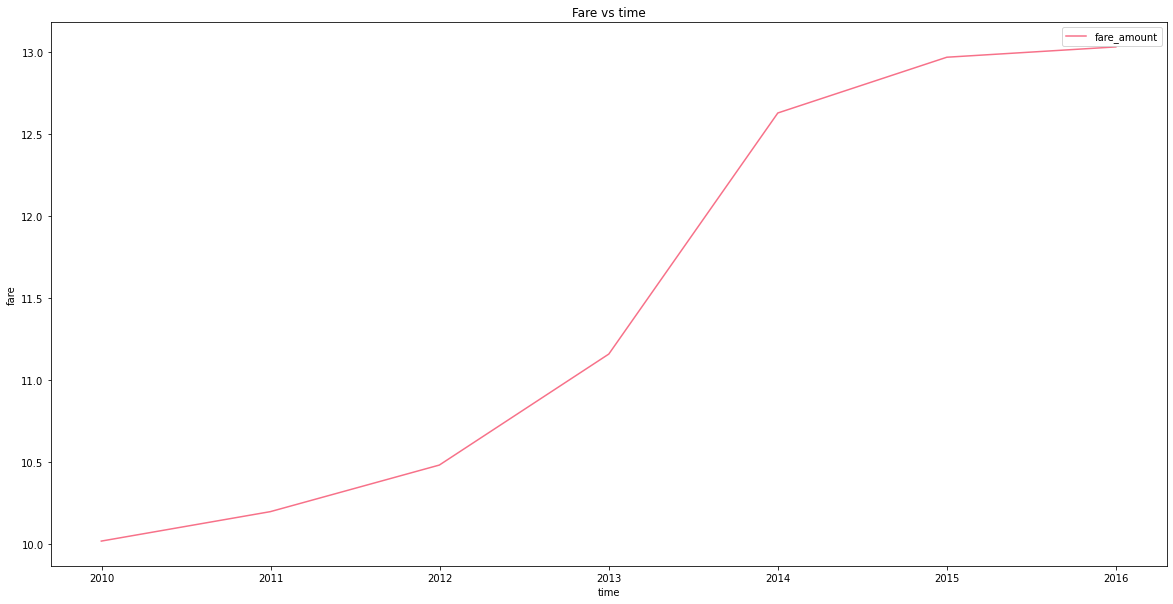

In [20]:
# Visualize effect of price and date

# Create a subset to visualize
subset = after_time_train[['time', 'fare_amount']]
subset = subset.set_index(subset['time'], drop=True)
subset_mean = subset.resample('A').mean()

# Plot

plt.figure(figsize=(20, 10))
sns.lineplot(data=subset_mean, palette='husl').set(ylabel='fare', 
                                                   title='Fare vs time')

[Text(0, 0.5, 'fare'), Text(0.5, 1.0, 'Fare vs time')]

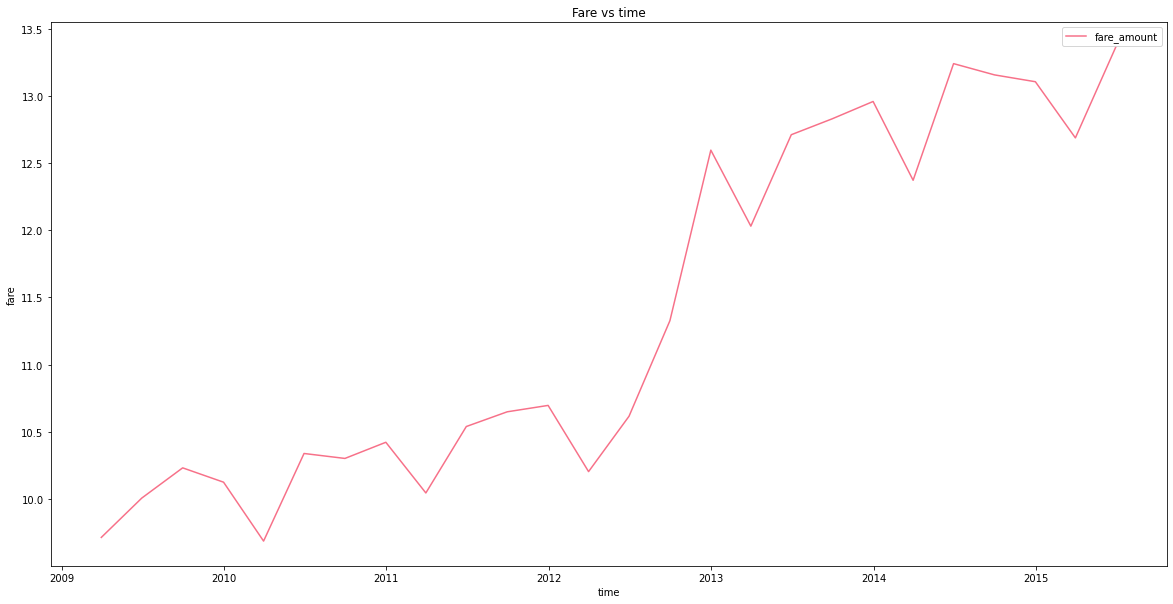

In [21]:
subset_mean = subset.resample('Q').mean()

# Plot

plt.figure(figsize=(20, 10))
sns.lineplot(data=subset_mean, palette='husl').set(ylabel='fare', 
                                                   title='Fare vs time')

[Text(0, 0.5, 'fare'), Text(0.5, 1.0, 'Fare vs time')]

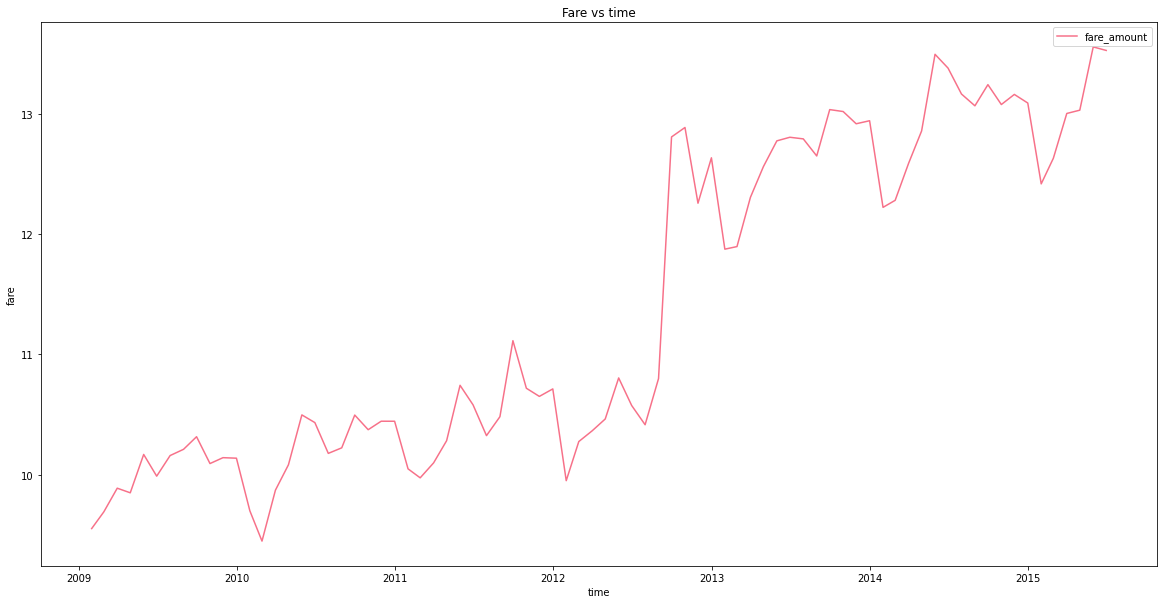

In [22]:
subset_mean = subset.resample('M').mean()

# Plot
plt.figure(figsize=(20, 10))
sns.lineplot(data=subset_mean, palette='husl').set(ylabel='fare', 
                                                   title='Fare vs time')

From the images above it is clear that the fare price increased from **2010** to **2016** with a sharp increase in **2012**.

In every year, there was a dip in the fare amount in a certain quarter, particularly the first quarter.





[Text(0.5, 1.0, 'Fare vs Day of Week')]

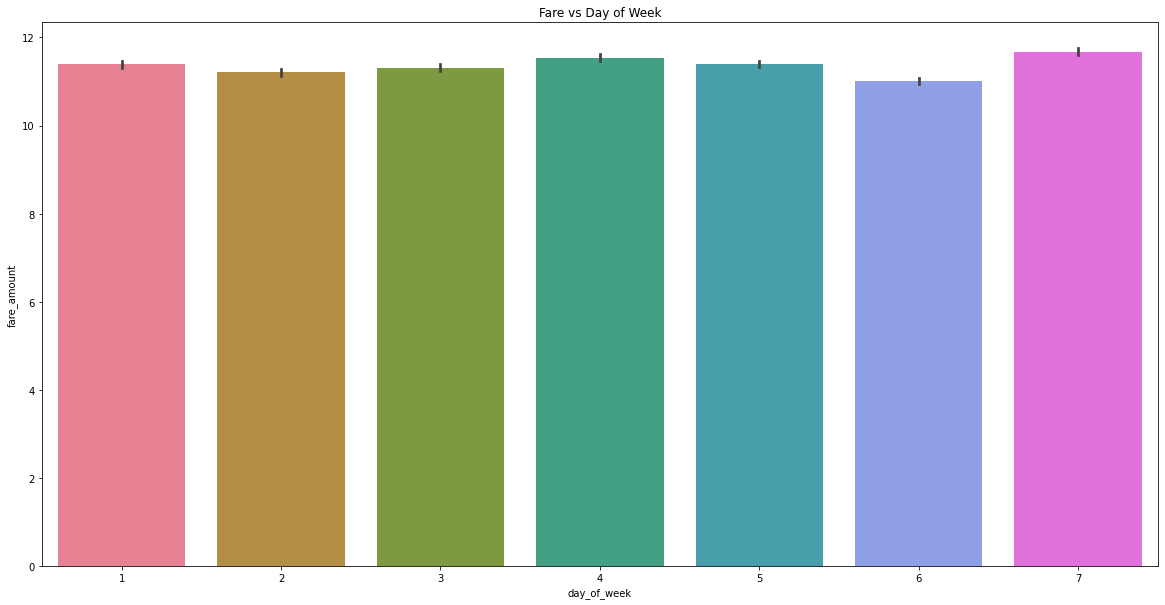

In [23]:
# Day of the week and price

plt.figure(figsize=(20, 10))
sns.barplot(x='day_of_week', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Day of Week')

[Text(0.5, 1.0, 'Day of Week Count')]

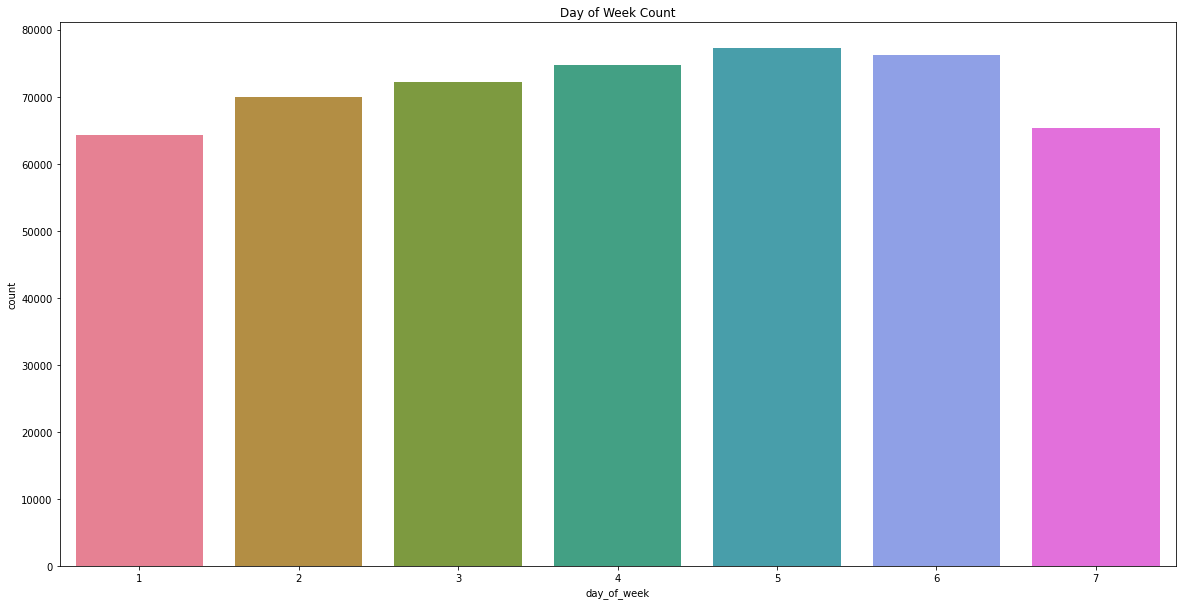

In [24]:
# Count vs Day of the week

plt.figure(figsize=(20, 10))
sns.countplot(x='day_of_week',
            palette='husl',
            data=after_time_train).set(title='Day of Week Count')

The day of the week does not seem to affect the change in price of the fares.


[Text(0.5, 1.0, 'Fare vs Holiday')]

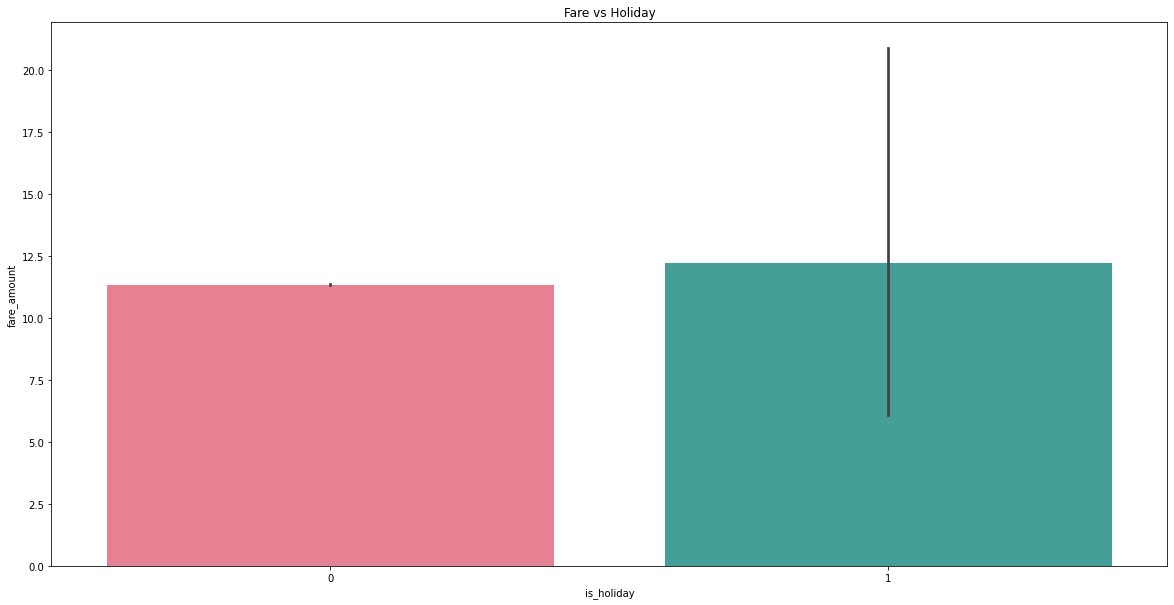

In [25]:
# Holiday vs Fare
plt.figure(figsize=(20, 10))
sns.barplot(x='is_holiday', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Holiday')

[Text(0.5, 1.0, 'Count of Holiday')]

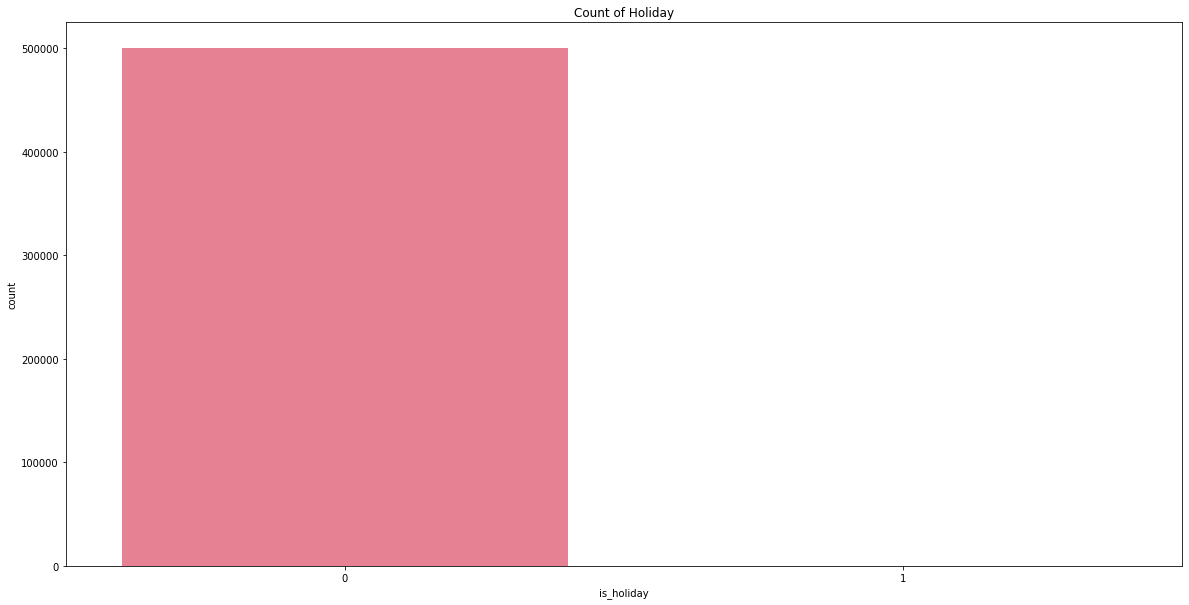

In [26]:
# Holiday

plt.figure(figsize=(20, 10))
sns.countplot(x='is_holiday',
            palette='husl',
            data=after_time_train).set(title='Count of Holiday')

In [27]:
# Check value counts
after_time_train.is_holiday.value_counts(normalize=True)

0    0.999994
1    0.000006
Name: is_holiday, dtype: float64

Only 3 days were holidays and their price varied. There isn't much disparity between a holiday and a non holiday.


[Text(0.5, 1.0, 'Fare vs Hour')]

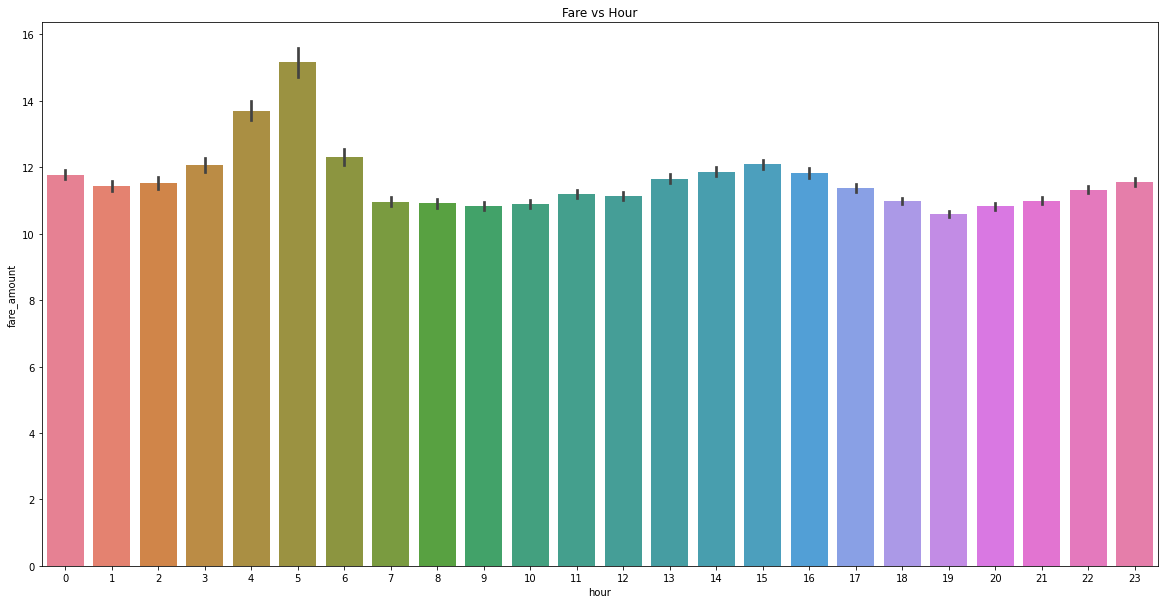

In [28]:
 # Hour vs Fare
plt.figure(figsize=(20, 10))
sns.barplot(x='hour', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Hour')

[Text(0.5, 1.0, 'Count of Hour')]

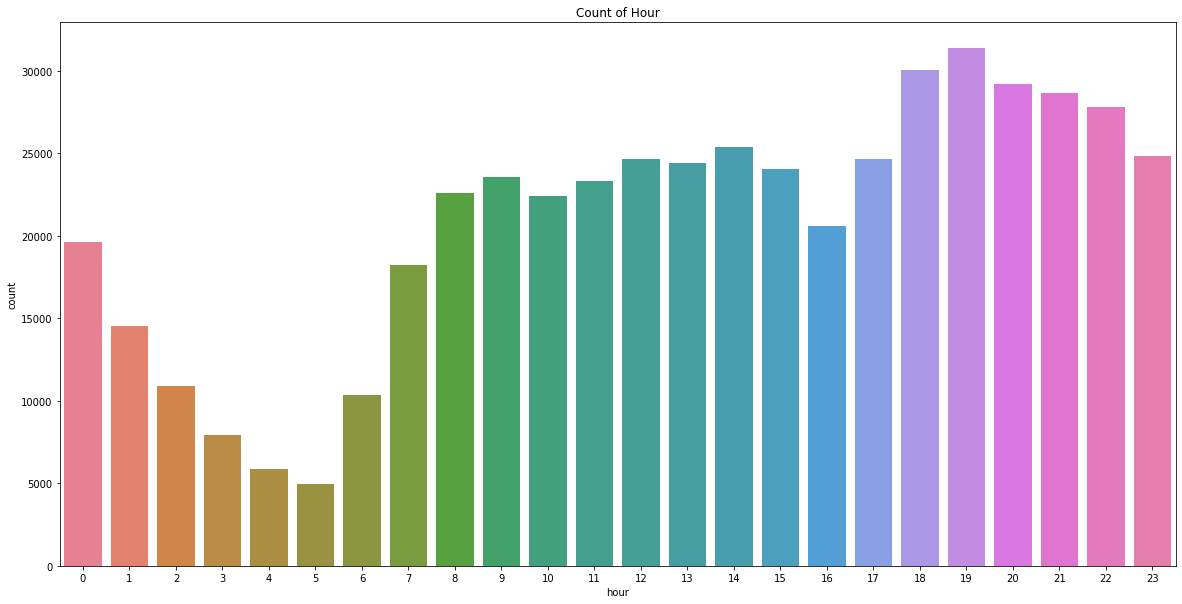

In [29]:
# Hour

plt.figure(figsize=(20, 10))
sns.countplot(x='hour',
            palette='husl',
            data=after_time_train).set(title='Count of Hour')

[Text(0.5, 1.0, 'Fare vs Hour')]

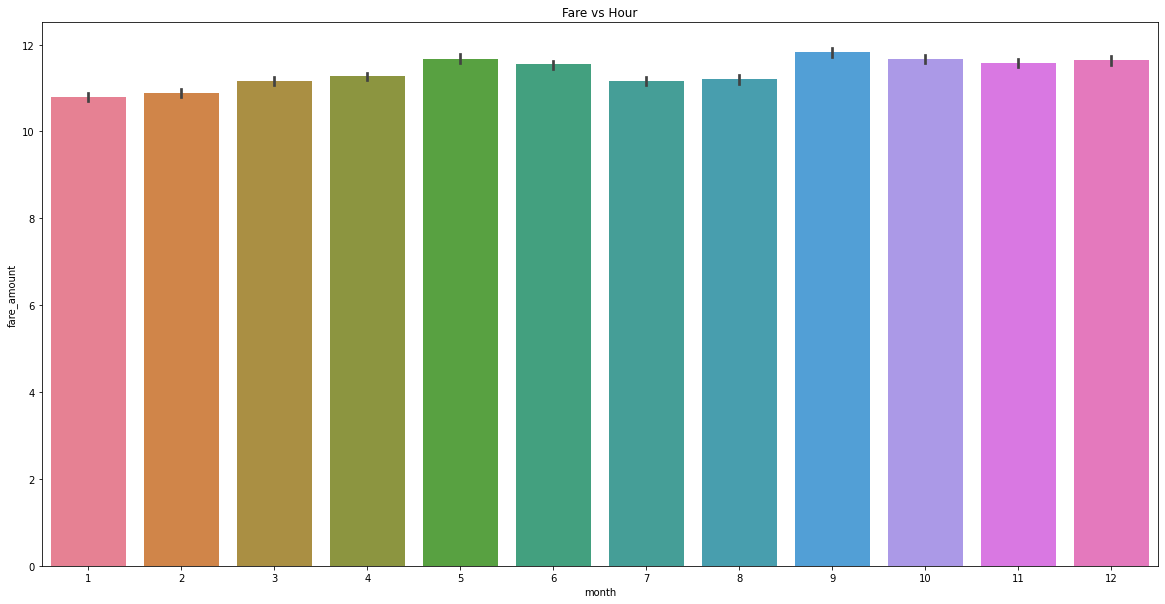

In [30]:
 # Month vs Fare
plt.figure(figsize=(20, 10))
sns.barplot(x='month', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Hour')

[Text(0.5, 1.0, 'Count of Hour')]

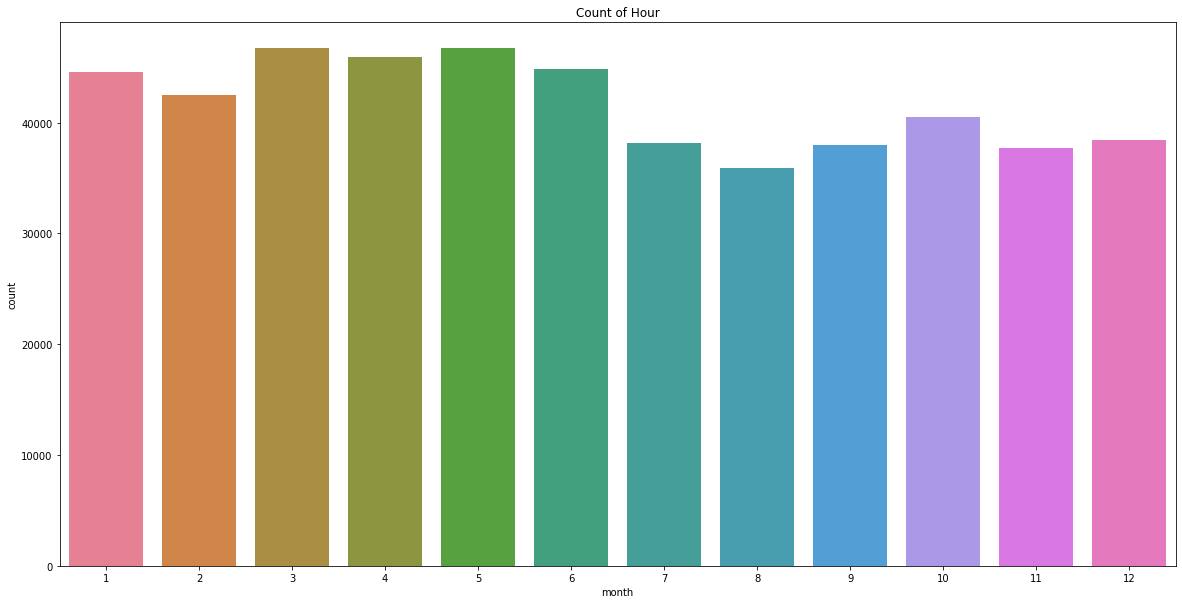

In [31]:
# Month

plt.figure(figsize=(20, 10))
sns.countplot(x='month',
            palette='husl',
            data=after_time_train).set(title='Count of Hour')

### Latitude and Latitude

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


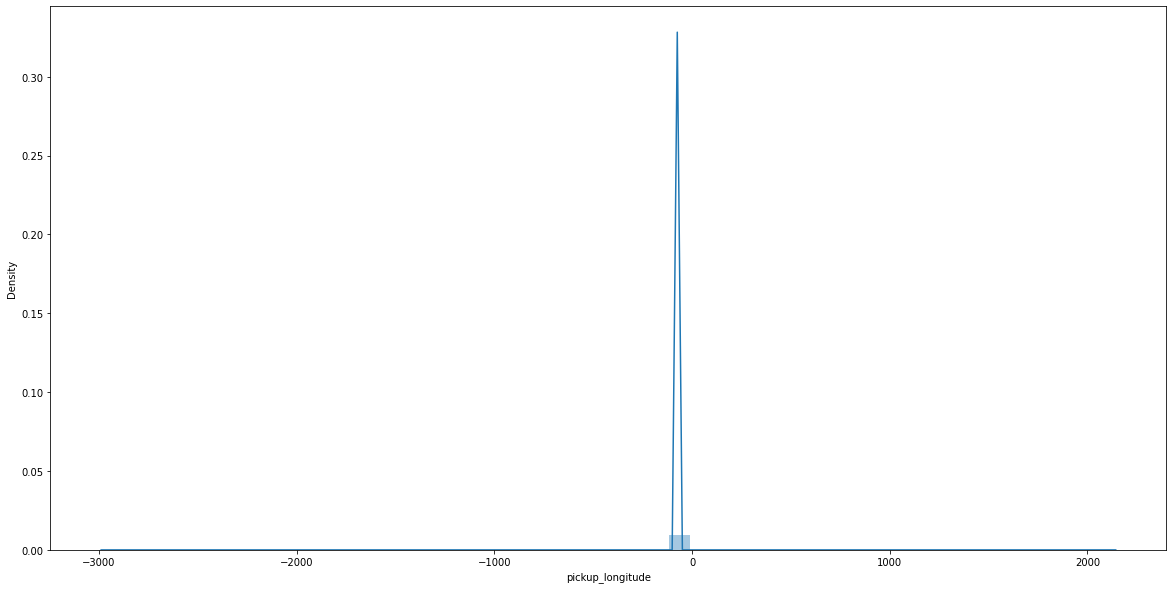

In [32]:
# Look at the distribution of lats and longitudes
plt.figure(figsize=(20, 10))
sns.distplot(after_time_train['pickup_longitude'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


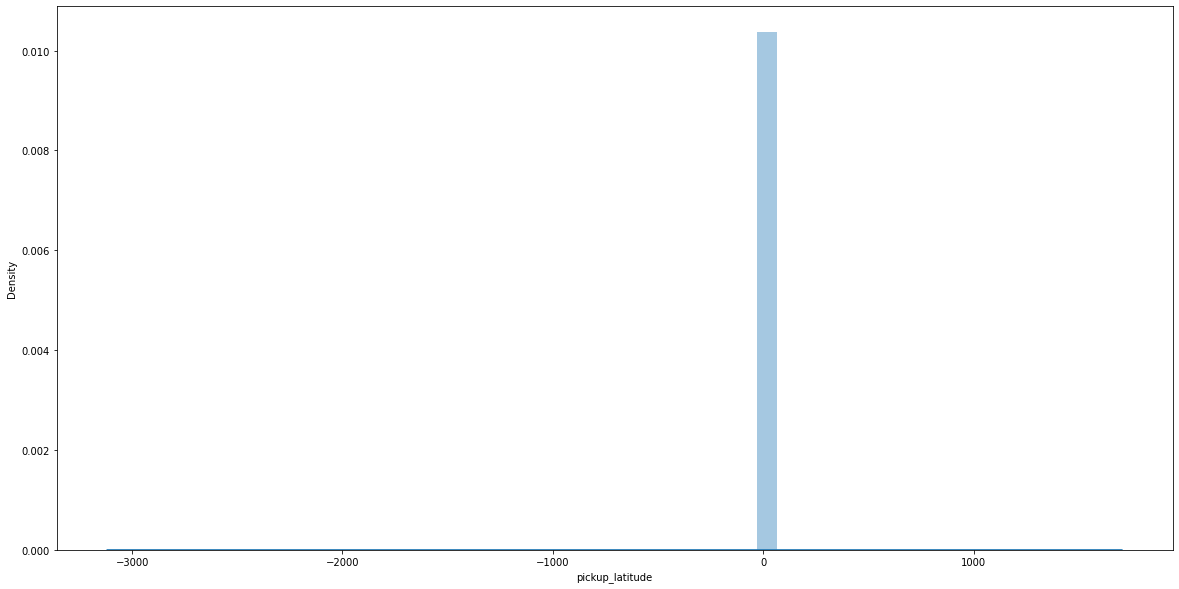

In [33]:
# Look at the distribution of lats and longitudes
plt.figure(figsize=(20, 10))
sns.distplot(after_time_train['pickup_latitude'])

There are outliers that we will need to get rid off. 

In [48]:
# Percentile range
def outlier_remover(columns, data):
  for column in columns:
    median = data[column].median()
    upper, lower = median + 0.3, median - 0.3 #np.percentile(data[column], [1,99])
    data[column] = np.clip(data[column], upper, lower)

  return data

In [49]:
train_without_outliers = outlier_remover(['pickup_latitude', 'pickup_longitude',
                 'dropoff_latitude', 'dropoff_longitude'],
                after_time_train)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

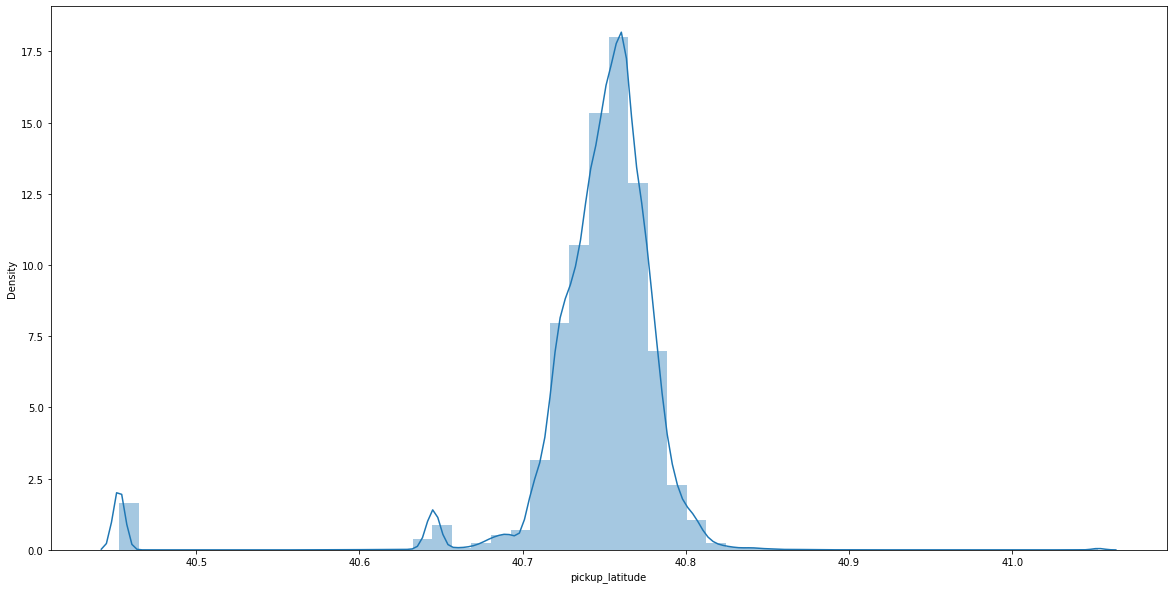

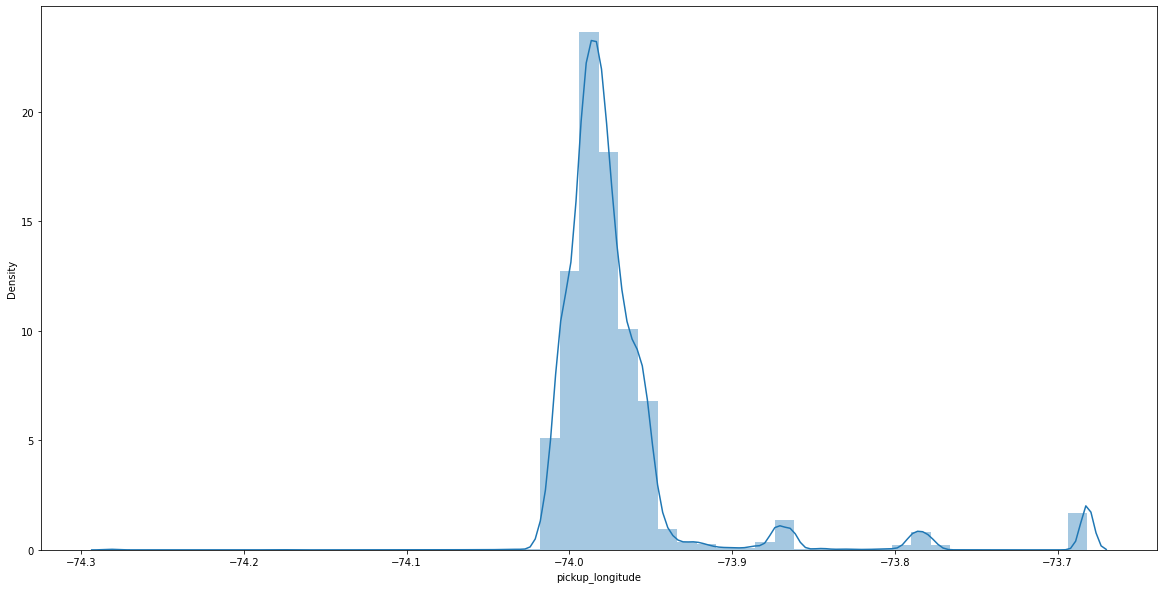

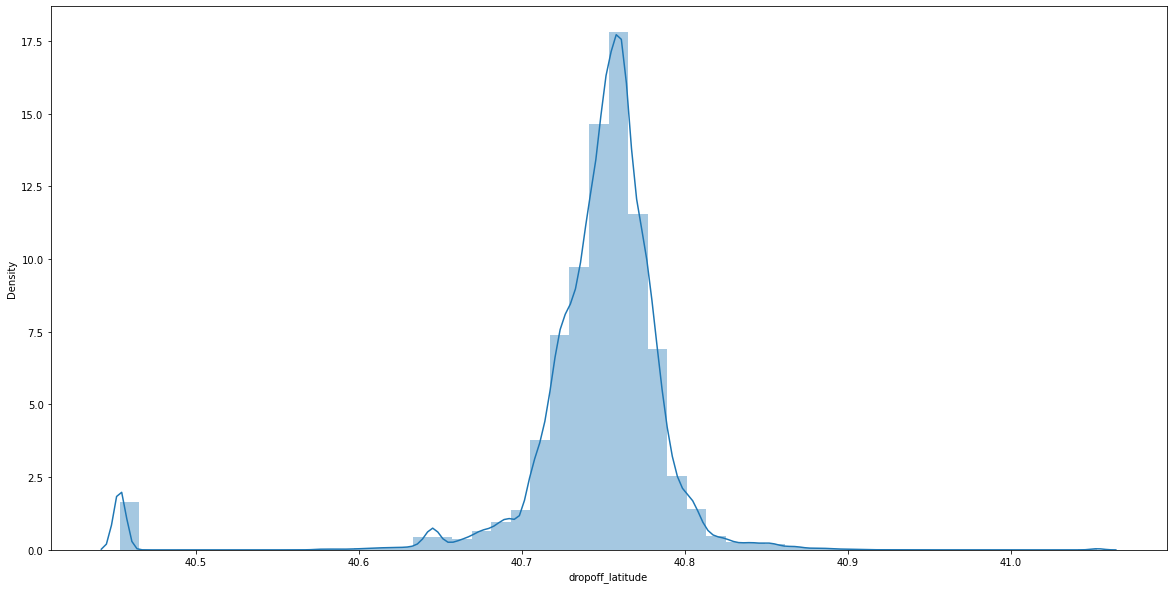

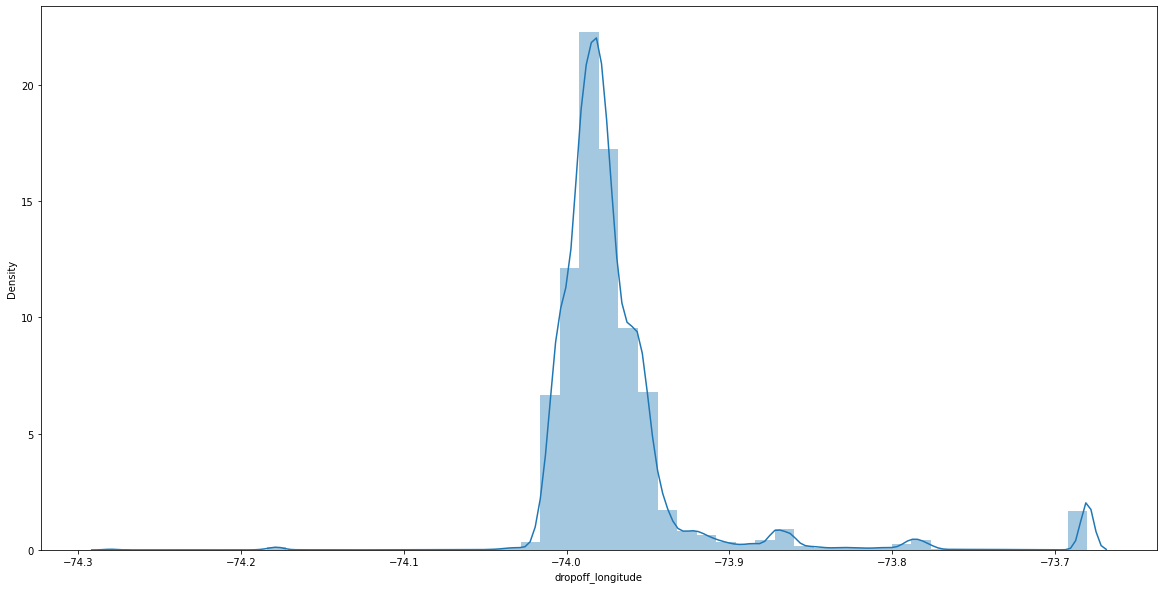

In [50]:
# Look at the distribution of lats and longitudes
for column in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
  plt.figure(figsize=(20, 10))
  sns.distplot(train_without_outliers[column])

In [51]:
# View
train_without_outliers.reset_index(drop=True, inplace=True)


In [52]:
pickup_latitudes = train_without_outliers['pickup_latitude'].values
pickup_longitudes = train_without_outliers['pickup_longitude'].values
dropoff_latitudes = train_without_outliers['dropoff_latitude'].values
dropoff_longitudes = train_without_outliers['dropoff_longitude'].values

pickup_coordinates = list(zip(pickup_latitudes, pickup_longitudes))
dropoff_coordinates = list(zip(dropoff_latitudes, dropoff_longitudes))


In [62]:
geocoder.reverse(pickup_coordinates[0]).raw['display_name'].split(', ')[2]

'Queens'

In [59]:
coords = []

for index, value in enumerate(pickup_coordinates):
  location = geocoder.reverse(value)
  print(index, location)
  suburb = location.raw['display_name']
  coords.append(suburb)


0 The Vitamin Shoppe, Queens Boulevard, Queens, Queens County, New York, 11375, United States
1 Gateway Plaza 200, 395, South End Avenue, Battery Park City, Manhattan, New York County, New York, 10280, United States
2 The Michelangelo, 152, West 51st Street, Theater District, Manhattan, New York County, New York, 10019, United States
3 LinkNYC, 141, 3rd Avenue, East Village, Manhattan, New York County, New York, 10003, United States
4 Building at 45 East 66th Street, 45, East 66th Street, Upper East Side, Manhattan, New York County, New York, 10021, United States
5 West 4th Street–Washington Square, West 4th Street, Washington Square Village, Manhattan Community Board 2, Manhattan, New York County, New York, 10014, United States
6 285, Madison Avenue, Murray Hill, Manhattan, New York County, New York, 10017, United States
7 1574, 1st Avenue, Yorkville, Manhattan, New York County, New York, 10028, United States
8 70, Charlton Street, Hudson Square, Manhattan, New York County, New York, 

KeyboardInterrupt: ignored

In [43]:
pickup_coordinates[11]

(39.75267, -72.98179)

#### Distance

In [66]:
def distance_getter(data):
  from geopy.distance import geodesic
  from geopy.extra.rate_limiter import RateLimiter
  geocoder = Nominatim(user_agent="my-application")
  geocode = RateLimiter(geocoder.geocode, min_delay_seconds = 1,
                        return_value_on_exception = None) 
  

  pickup_latitudes = data['pickup_latitude'].values
  pickup_longitudes = data['pickup_longitude'].values
  dropoff_latitudes = data['dropoff_latitude'].values
  dropoff_longitudes = data['dropoff_longitude'].values

  pickup_coordinates = list(zip(pickup_latitudes, pickup_longitudes))
  dropoff_coordinates = list(zip(dropoff_latitudes, dropoff_longitudes))

  distance = [ geodesic(x,y).km  for x, y in zip(pickup_coordinates, dropoff_coordinates)]
  #pickup_road = [geocoder.reverse(value).raw['address']['road'] for value in pickup_coordinates]
  #dropoff_road = [geocoder.reverse(value).raw['address']['road'] for value in dropoff_coordinates]
  #pickup_suburb = [geocoder.reverse(value).raw['display_name'].split(', ')[2] for value in pickup_coordinates]
  #dropoff_suburb = [geocoder.reverse(value).raw['display_name'].split(', ')[2] for value in dropoff_coordinates]

  data['distance'] = distance
  #data['pickup_road'] = pickup_road
  #data['dropoff_road'] = dropoff_road
  #data['pickup_suburb'] = pickup_suburb
  #data['dropoff_suburb'] = dropoff_suburb

  return data

In [67]:
train_with_distance = distance_getter(train_without_outliers)

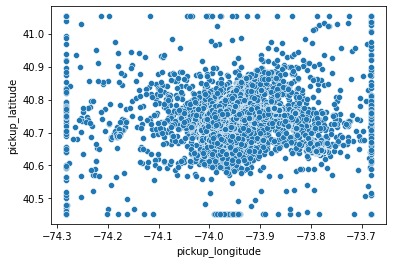

In [68]:
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=train_with_distance)

## Data Splitting

In [ ]:
train_with_distance.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'minute', 'month', 'year', 'day', 'time', 'day_of_week', 'is_holiday',
       'distance'],
      dtype='object')

In [84]:
# Choose columns
to_use = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','hour',
        'month', 'year', 'day_of_week',
       'distance']

x = train_with_distance[to_use]
y = train_with_distance['fare_amount']

In [85]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

# Modelling

Modelling will be using statistical methods and using a neural network

### Statistical Modelling
The use of xgboost and catboost

In [74]:
## define a model Trainer
def model_trainer(models, x_train, y_train, x_val, y_val):
  for model in models:
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    r2 = r2_score(y_val, predictions)
    

    print(f'Model {model} , rmse: {rmse}, r2_score: {r2}')

In [75]:
# Define models
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
cat = CatBoostRegressor(verbose=False, random_state=42)

models = [xgb, cat]

In [86]:
model_trainer(models, x_train, y_train, x_test, y_test)

Model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1) , rmse: 4.7080278396606445, r2_score: 0.7763582888417286
Model <catboost.core.CatBoostRegressor object at 0x7f3a96938610> , rmse: 4.409033296348449, r2_score: 0.803862130682439


In [79]:
cat.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.11338800191879272,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 42,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.800000011920929

In [80]:
# cat
cat.fit(x_train, y_train)
predictions = cat.predict(x_test)
rmse = mean_squared_error(y_test, predictions, squared=False)

In [81]:
print(rmse)

4.406864105772871


In [82]:
# View feature importance
def plot_feature_importance(trained_model, features_train):

    #Create arrays from feature importance and feature names
    feature_importance = trained_model.feature_importances_
    feature_names = features_train.columns

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.set_style('whitegrid')
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                palette='husl')
    #Add chart labels
    plt.title('FEATURE IMPORTANCES')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

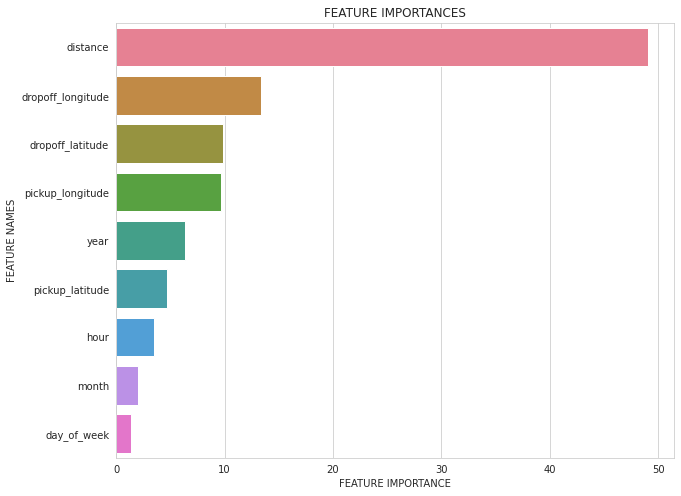

In [87]:
plot_feature_importance(cat, x_train)

## Neural Network

In [106]:
def rmse(y_true, y_pred):
  return tf.math.sqrt(tf.keras.losses.MSE(y_true, y_pred))

In [116]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(9,)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(units=1)
    ]
)

model.compile(loss= rmse, optimizer='adam')

In [114]:
history = model.fit(x_train, y_train, 
                        epochs=10, batch_size=64, 
                        validation_data = (x_test, y_test),
                        validation_steps = 32)

Epoch 1/10
6250/6250 [==============================] - 10s 2ms/step - loss: 9.7756 - val_loss: 3.8299
Epoch 2/10
6250/6250 [==============================] - 10s 2ms/step - loss: 4.5949 - val_loss: 4.3418
Epoch 3/10
6250/6250 [==============================] - 9s 2ms/step - loss: 4.4373 - val_loss: 4.0789
Epoch 4/10
6250/6250 [==============================] - 9s 2ms/step - loss: 4.3678 - val_loss: 3.7789
Epoch 5/10
6250/6250 [==============================] - 10s 2ms/step - loss: 3.9383 - val_loss: 3.9059
Epoch 6/10
6250/6250 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 7/10
6250/6250 [==============================] - 10s 2ms/step - loss: nan - val_loss: nan
Epoch 8/10
6250/6250 [==============================] - 10s 2ms/step - loss: nan - val_loss: nan
Epoch 9/10
6250/6250 [==============================] - 10s 2ms/step - loss: nan - val_loss: nan
Epoch 10/10
6250/6250 [==============================] - 10s 2ms/step - loss: nan - val_loss: nan


In [100]:
def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **accuracy**

    :param all: bool
    default=True. If true, overrides metric and plots figures of accuracy and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation Accuracy',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train Accuracy',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation Accuracy plots',
                             xaxis_title='Epochs',
                             yaxis_title='Accuracy')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['accuracy']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='Accuracy',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='Accuracy plot',
                             xaxis_title='Epochs',
                             yaxis_title='Accuracy')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


In [115]:
plot_interactive_figures(history, metric='loss', all=False)